In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

class TextPreprocessor:
    # Example usage:
    PATH_TRAIN_DATA = 'InputData/train.csv'
    PATH_TEST_DATA = 'InputData/test.csv'
    DATA_SET_HEADER = ['polarity', 'title', 'review']
    def __init__(self, max_features=5000, max_length = 100):
        """
        Constructor to initialize paths, column headers, and TF-IDF settings.
        
        :param max_features: [Maximum number of words in the vocabulary] or [Maximum number of words to use for TF-IDF vectorization]
        :param max_length: Maximum length of the input sequences
        """
        self.max_features = max_features
        self.max_length=max_length
        self.vectorizer = TfidfVectorizer(max_features=self.max_features)

    def sampling_data(self,df, num_sample=10000):
        """
        Random sampling of {num_sample} reviews
        
        :param df: Input DataFrame
        :param num_sample: Number to sample
        :return: Sampled DataFrame
        """
        df = df.sample(n=num_sample, random_state=42)  # random_state ensures reproducibility

        # Display the sampled data
        print(f'Sampled Data Shape:\n{df.shape}') 

        return df

    def load_data(self, num_sample=0, test_ratio=0.2):
        """
        Load training and test datasets.
        
        :return: Loaded DataFrames for train and test datasets
        """
        df_train = pd.read_csv(self.PATH_TRAIN_DATA, names=self.DATA_SET_HEADER)
        df_test = pd.read_csv(self.PATH_TEST_DATA, names=self.DATA_SET_HEADER)
        if num_sample == 0:
            pass
        else:
            df_train = self.sampling_data(df_train, num_sample=num_sample)
            df_test = self.sampling_data(df_test, num_sample=int(num_sample*test_ratio))


        df_train = df_train.dropna()
        df_test = df_test.dropna()

        return df_train, df_test

    def preprocess(self, df):
        """
        Preprocess the dataset by converting polarity to binary labels.
        
        :param df: Input DataFrame
        :return: Preprocessed DataFrame with binary labels
        """
        df['polarity'] = df['polarity'].map({1: 0, 2: 1})  # 1 for negative, 2 for positive
        return df

    def split_data(self, df):
        """
        Split the dataset into training and test sets.
        
        :param df: Input DataFrame
        :return: Training and test sets for X and y
        """
        X = df['review']  # Feature: review text
        y = df['polarity']  # Target: sentiment polarity

        return X, y

    def vectorize_text(self, X_train, X_test):
        """
        Perform TF-IDF vectorization on the training and test datasets.
        
        :param X_train: Training text data
        :param X_test: Test text data
        :return: TF-IDF transformed X_train and X_test
        """
        X_train_tfidf = self.vectorizer.fit_transform(X_train)
        X_test_tfidf = self.vectorizer.transform(X_test)
        return X_train_tfidf, X_test_tfidf
    
    def tokenization_and_padding(self, X_train, X_test):
        """
        Tokenization and Padding
        Pad sequences to ensure uniform input length

        :param X_train: Training text data
        :param X_test: Test text data
        :return: Padded Sequences
        """
        self.tokenizer = Tokenizer(num_words=self.max_features)
        self.tokenizer.fit_on_texts(X_train)

        X_train_seq = self.tokenizer.texts_to_sequences(X_train)
        X_test_seq = self.tokenizer.texts_to_sequences(X_test)

        X_train_pad = pad_sequences(X_train_seq, maxlen=self.max_length)
        X_test_pad = pad_sequences(X_test_seq, maxlen=self.max_length)
        return X_train_pad, X_test_pad

2024-09-23 21:07:00.503208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 21:07:00.512276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 21:07:00.514814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 21:07:00.521456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 21:07:00.910344: W tensorflow/compiler/tf2

In [2]:
processor = TextPreprocessor()
x_train, x_test = processor.load_data()

In [3]:
def filter_top_70_percent(X_train):
    # 문장 길이 계산
    X_train['review_length'] = X_train['review'].apply(len)
    
    # 문장 길이별 카운트 계산
    length_counts = X_train['review_length'].value_counts().reset_index()
    length_counts.columns = ['review_length', 'count']
    length_counts = length_counts.sort_values('review_length')
    
    # 누적 합과 백분율 계산
    length_counts['cumulative_sum'] = length_counts['count'].cumsum()
    length_counts['cumulative_percentage'] = 100 * length_counts['cumulative_sum'] / length_counts['count'].sum()
    
    # 70%에 해당하는 문장 길이 찾기
    threshold_70 = length_counts[length_counts['cumulative_percentage'] >= 70].iloc[0]['review_length']
    
    # 70% 범위 이내의 리뷰만 필터링
    filtered_data = X_train[X_train['review_length'] <= threshold_70]
    
    return filtered_data


In [4]:
x_train

,polarity,title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
...,...,...,...
3599995,1,Don't do it!!,The high chair looks great when it first comes...
3599996,1,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...
3599997,1,"compact, but hard to clean","We have a small house, and really wanted two o..."
3599998,1,what is it saying?,not sure what this book is supposed to be. It ...


In [5]:
f_X_train = filter_top_70_percent(x_train)
f_X_train

,polarity,title,review,review_length
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,394
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,470
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",425
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...,506
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...,506
...,...,...,...,...
3599992,2,AWESOME,Absolutely amazing so relieving of my neck pai...,249
3599993,1,What A Slap In The Face To Masami Ueda,Do NOT buy this cd. Ever. This was probably ju...,301
3599994,1,Too simplistic,While Mr. Harrison makes some extremely valid ...,483
3599995,1,Don't do it!!,The high chair looks great when it first comes...,396


In [17]:
# Sample x_train and x_test datasets
# Assuming x_train and x_test are pandas DataFrames with the first column containing sentences
# Combine x_train and x_test for analysis
combined_data = pd.concat([x_train, x_test], ignore_index=True)

# Calculate sentence lengths
combined_data['sentence_length'] = combined_data.iloc[:, 2].apply(len)

# Count how many sentences have the same length
length_counts = combined_data['sentence_length'].value_counts().reset_index()
length_counts.columns = ['sentence_length', 'count']

# Sort by sentence length for better readability
length_counts = length_counts.sort_values('sentence_length')

/tmp/ipykernel_393115/3790212886.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['sentence_length'] = combined_data.iloc[:, 2].apply(len)


In [18]:
x_train

,polarity,title,review,review_length,sentence_length
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,394,394
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,470,470
2,2,Amazing!,This soundtrack is my favorite music of all ti...,750,750
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,721,721
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",425,425
...,...,...,...,...,...
3599995,1,Don't do it!!,The high chair looks great when it first comes...,396,396
3599996,1,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...,945,945
3599997,1,"compact, but hard to clean","We have a small house, and really wanted two o...",928,928
3599998,1,what is it saying?,not sure what this book is supposed to be. It ...,464,464


In [15]:
x_test

,polarity,title,review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
...,...,...,...
399995,1,Unbelievable- In a Bad Way,We bought this Thomas for our son who is a hug...
399996,1,"Almost Great, Until it Broke...",My son recieved this as a birthday gift 2 mont...
399997,1,Disappointed !!!,"I bought this toy for my son who loves the ""Th..."
399998,2,Classic Jessica Mitford,This is a compilation of a wide range of Mitfo...


In [19]:
combined_data

,polarity,title,review,review_length,sentence_length
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,394,394
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,470,470
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",425,425
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...,506,506
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...,506,506
...,...,...,...,...,...
3599992,2,AWESOME,Absolutely amazing so relieving of my neck pai...,249,249
3599993,1,What A Slap In The Face To Masami Ueda,Do NOT buy this cd. Ever. This was probably ju...,301,301
3599994,1,Too simplistic,While Mr. Harrison makes some extremely valid ...,483,483
3599995,1,Don't do it!!,The high chair looks great when it first comes...,396,396


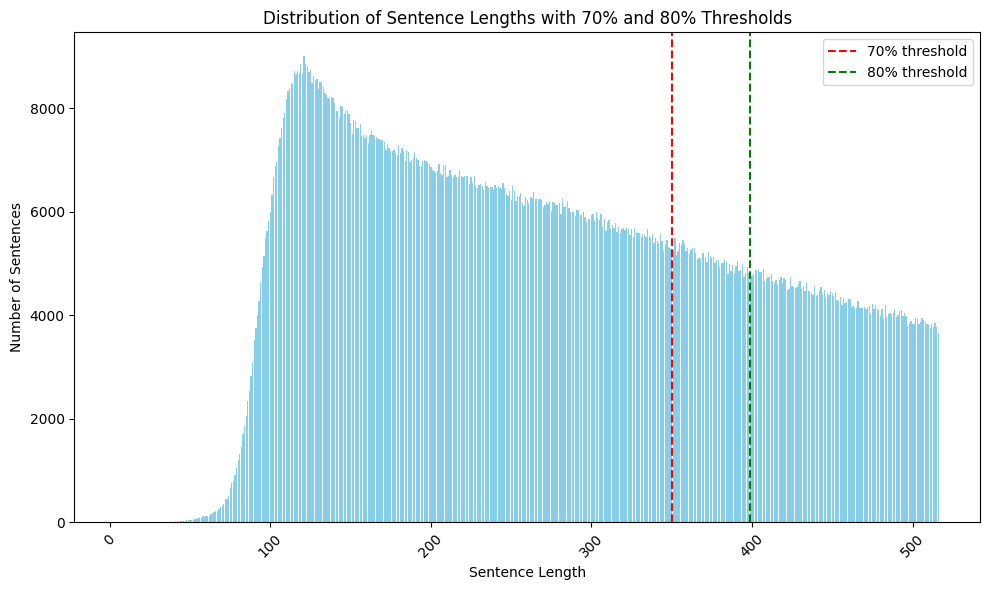

: 

In [20]:
import matplotlib.pyplot as plt

# Calculate cumulative percentage
length_counts['cumulative_sum'] = length_counts['count'].cumsum()
length_counts['cumulative_percentage'] = 100 * length_counts['cumulative_sum'] / length_counts['count'].sum()

# Find the sentence lengths that correspond to 70% and 80% of the data
threshold_70 = length_counts[length_counts['cumulative_percentage'] >= 70].iloc[0]['sentence_length']
threshold_80 = length_counts[length_counts['cumulative_percentage'] >= 80].iloc[0]['sentence_length']

# Plotting the length_counts DataFrame
plt.figure(figsize=(10, 6))
plt.bar(length_counts['sentence_length'], length_counts['count'], color='skyblue')

# Add vertical lines for 70% and 80% thresholds
plt.axvline(x=threshold_70, color='red', linestyle='--', label='70% threshold')
plt.axvline(x=threshold_80, color='green', linestyle='--', label='80% threshold')

# Labels and title
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Sentence Lengths with 70% and 80% Thresholds')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()